Every day, the average human heart beats around 100,000 times, pumping 2,000 gallons of blood through the body. Inside your body there are 60,000 miles of blood vessels.
The signs of a woman having a heart attack are much less noticeable than the signs of a male. In women, heart attacks may feel uncomfortable squeezing, pressure, fullness, or pain in the center of the chest. It may also cause pain in one or both arms, the back, neck, jaw or stomach, shortness of breath, nausea and other symptoms. Men experience typical symptoms of heart attack, such as chest pain , discomfort, and stress. They may also experience pain in other areas, such as arms, neck , back, and jaw, and shortness of breath, sweating, and discomfort that mimics heartburn.
It’s a lot of work for an organ which is just like a large fist and weighs between 8 and 12 ounces.

source: healthblog.uofmhealth


## Dataset Columns:
* id (Unique id for each patient)
* age (Age of the patient in years)
* origin (place of study)
* sex (Male/Female)
* cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
* trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
* chol (serum cholesterol in mg/dl)
* fbs (if fasting blood sugar > 120 mg/dl)
* restecg (resting electrocardiographic results)
* Values: [normal, stt abnormality, lv hypertrophy]
* thalach: maximum heart rate achieved
* exang: exercise-induced angina (True/ False)
* oldpeak: ST depression induced by exercise relative to rest
* slope: the slope of the peak exercise ST segment
* ca: number of major vessels (0-3) colored by fluoroscopy
* thal: [normal; fixed defect; reversible defect]
* num: the predicted attribute

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

import seaborn as sns
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,roc_curve, roc_auc_score, f1_score, auc

import warnings

## 1. Load data

In [2]:
#install uci archieve library
!pip install ucimlrepo

In [3]:
#import uci dataset repository libray
from ucimlrepo import fetch_ucirepo


# Fetch the UCI Heart Disease dataset
heart_disease = fetch_ucirepo(id=45)

# Data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets
# metadata
display(heart_disease.metadata)

# variable information
display(heart_disease.variables)

{'uci_id': 45,
 'name': 'Heart Disease',
 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease',
 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv',
 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach',
 'area': 'Health and Medicine',
 'tasks': ['Classification'],
 'characteristics': ['Multivariate'],
 'num_instances': 303,
 'num_features': 13,
 'feature_types': ['Categorical', 'Integer', 'Real'],
 'demographics': ['Age', 'Sex'],
 'target_col': ['num'],
 'index_col': None,
 'has_missing_values': 'yes',
 'missing_values_symbol': 'NaN',
 'year_of_dataset_creation': 1989,
 'last_updated': 'Fri Nov 03 2023',
 'dataset_doi': '10.24432/C52P4X',
 'creators': ['Andras Janosi',
  'William Steinbrunn',
  'Matthias Pfisterer',
  'Robert Detrano'],
 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.',
  'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M.

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


### Prepare a dataframe

In [4]:


# Create a DataFrame
data = pd.DataFrame(data=X, columns=heart_disease.data.feature_names)

# Create a mapping for categorical variables as per given meta information
cp_mapping = {
    0: 'typical angina',
    1: 'atypical angina',
    2: 'non-anginal',
    3: 'asymptomatic'
}

restecg_mapping = {
    0: 'normal',
    1: 'lv hypertrophy',
    2: 'st-t wave abnormality'
}

slope_mapping = {
    0: 'upsloping',
    1: 'flat',
    2: 'downsloping'
}

thal_mapping = {
    3: 'normal',
    6: 'fixed defect',
    7: 'reversable defect'
}

# Map categorical variables to their respective values
data['cp'] = data['cp'].map(cp_mapping)
data['restecg'] = data['restecg'].map(restecg_mapping)
data['slope'] = data['slope'].map(slope_mapping)
data['thal'] = data['thal'].map(thal_mapping)

# Map binary variables to boolean values
data['sex'] = data['sex'].apply(lambda x: 'Male' if x == 1 else 'Female')
data['fbs'] = data['fbs'].apply(lambda x: bool(x))
data['exang'] = data['exang'].apply(lambda x: bool(x))

# Reorder columns as per the desired format
data = data[['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']]
data['num'] = y

# Save the DataFrame to a CSV file
data.to_csv('heart_disease_data_formatted.csv', index=False)

# Display the first few rows of the formatted DataFrame
display(data.head())


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,Male,atypical angina,145,233,True,st-t wave abnormality,150,False,2.3,NaN,0.0,fixed defect,0
1,67,Male,NaN,160,286,False,st-t wave abnormality,108,True,1.5,downsloping,3.0,normal,2
2,67,Male,NaN,120,229,False,st-t wave abnormality,129,True,2.6,downsloping,2.0,reversable defect,1
3,37,Male,asymptomatic,130,250,False,normal,187,False,3.5,NaN,0.0,normal,0
4,41,Female,non-anginal,130,204,False,st-t wave abnormality,172,False,1.4,flat,0.0,normal,0


## 2. EDA

EDA is an essential step to inspect the data, so to better understand nature of the given data.

In [5]:
column_rename = {
    'sex': 'sex',
    'cp': 'chest_Pain_Type',
    'trestbps': 'resting_BP',
    'chol': 'cholesterol',
    'fbs': 'fasting_Blood_Sugar',
    'restecg': 'resting_ECG',
    'thalach': 'max_Heart_Rate',
    'exang': 'exercise_Induced_Angina',
    'oldpeak': 'st_Depression',
    'slope': 'slope_of_ST',
    'ca': 'number_of_Vessels',
    'thal': 'thalassemia_Type',
    'num': 'heart_Disease_Severity'
}

data.rename(columns=column_rename, inplace=True)

# Display the first few rows with new column names
data.head()

,age,sex,chest_Pain_Type,resting_BP,cholesterol,fasting_Blood_Sugar,resting_ECG,max_Heart_Rate,exercise_Induced_Angina,st_Depression,slope_of_ST,number_of_Vessels,thalassemia_Type,heart_Disease_Severity
0,63,Male,atypical angina,145,233,True,st-t wave abnormality,150,False,2.3,NaN,0.0,fixed defect,0
1,67,Male,NaN,160,286,False,st-t wave abnormality,108,True,1.5,downsloping,3.0,normal,2
2,67,Male,NaN,120,229,False,st-t wave abnormality,129,True,2.6,downsloping,2.0,reversable defect,1
3,37,Male,asymptomatic,130,250,False,normal,187,False,3.5,NaN,0.0,normal,0
4,41,Female,non-anginal,130,204,False,st-t wave abnormality,172,False,1.4,flat,0.0,normal,0


### To convert the target class into a binary classification database where 0 represents negative class, and all other values represent positive class
- negtive class means no heart disease
- positive class means possibility to have heart disease

In [6]:
data['heart_Disease_Severity'] = data['heart_Disease_Severity'].apply(lambda x: 0 if x == 0 else 1)
data.head()

,age,sex,chest_Pain_Type,resting_BP,cholesterol,fasting_Blood_Sugar,resting_ECG,max_Heart_Rate,exercise_Induced_Angina,st_Depression,slope_of_ST,number_of_Vessels,thalassemia_Type,heart_Disease_Severity
0,63,Male,atypical angina,145,233,True,st-t wave abnormality,150,False,2.3,NaN,0.0,fixed defect,0
1,67,Male,NaN,160,286,False,st-t wave abnormality,108,True,1.5,downsloping,3.0,normal,1
2,67,Male,NaN,120,229,False,st-t wave abnormality,129,True,2.6,downsloping,2.0,reversable defect,1
3,37,Male,asymptomatic,130,250,False,normal,187,False,3.5,NaN,0.0,normal,0
4,41,Female,non-anginal,130,204,False,st-t wave abnormality,172,False,1.4,flat,0.0,normal,0


In [7]:
data['heart_Disease_Severity'].value_counts()

0    164
1    139
Name: heart_Disease_Severity, dtype: int64

In [8]:
data

,age,sex,chest_Pain_Type,resting_BP,cholesterol,fasting_Blood_Sugar,resting_ECG,max_Heart_Rate,exercise_Induced_Angina,st_Depression,slope_of_ST,number_of_Vessels,thalassemia_Type,heart_Disease_Severity
0,63,Male,atypical angina,145,233,True,st-t wave abnormality,150,False,2.3,NaN,0.0,fixed defect,0
1,67,Male,NaN,160,286,False,st-t wave abnormality,108,True,1.5,downsloping,3.0,normal,1
2,67,Male,NaN,120,229,False,st-t wave abnormality,129,True,2.6,downsloping,2.0,reversable defect,1
3,37,Male,asymptomatic,130,250,False,normal,187,False,3.5,NaN,0.0,normal,0
4,41,Female,non-anginal,130,204,False,st-t wave abnormality,172,False,1.4,flat,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,Male,atypical angina,110,264,False,normal,132,False,1.2,downsloping,0.0,reversable defect,1
299,68,Male,NaN,144,193,True,normal,141,False,3.4,downsloping,2.0,reversable defect,1
300,57,Male,NaN,130,131,False,normal,115,True,1.2,downsloping,1.0,reversable defect,1
301,57,Female,non-anginal,130,236,False,st-t wave abnormality,174,False,0.0,downsloping,1.0,normal,1


In [9]:
data.dtypes

age                          int64
sex                         object
chest_Pain_Type             object
resting_BP                   int64
cholesterol                  int64
fasting_Blood_Sugar           bool
resting_ECG                 object
max_Heart_Rate               int64
exercise_Induced_Angina       bool
st_Depression              float64
slope_of_ST                 object
number_of_Vessels          float64
thalassemia_Type            object
heart_Disease_Severity       int64
dtype: object

In [10]:
# Initialize lists to store feature names
numerical_features = []
categorical_features = []

# Loop through the columns and classify them
for column in data.columns:
    if pd.api.types.is_float_dtype(data[column]) or pd.api.types.is_integer_dtype(data[column]):
        numerical_features.append(column)
    else:
        categorical_features.append(column)

# Print the categorized features
print("Categorical Features:")
print(categorical_features)

print("\nNumerical Features:")
print(numerical_features)

Categorical Features:
['sex', 'chest_Pain_Type', 'fasting_Blood_Sugar', 'resting_ECG', 'exercise_Induced_Angina', 'slope_of_ST', 'thalassemia_Type']

Numerical Features:
['age', 'resting_BP', 'cholesterol', 'max_Heart_Rate', 'st_Depression', 'number_of_Vessels', 'heart_Disease_Severity']


### 2.1. Univariant Analysis

In [11]:
# Categorical Features
data[categorical_features]

,sex,chest_Pain_Type,fasting_Blood_Sugar,resting_ECG,exercise_Induced_Angina,slope_of_ST,thalassemia_Type
0,Male,atypical angina,True,st-t wave abnormality,False,NaN,fixed defect
1,Male,NaN,False,st-t wave abnormality,True,downsloping,normal
2,Male,NaN,False,st-t wave abnormality,True,downsloping,reversable defect
3,Male,asymptomatic,False,normal,False,NaN,normal
4,Female,non-anginal,False,st-t wave abnormality,False,flat,normal
...,...,...,...,...,...,...,...
298,Male,atypical angina,False,normal,False,downsloping,reversable defect
299,Male,NaN,True,normal,False,downsloping,reversable defect
300,Male,NaN,False,normal,True,downsloping,reversable defect
301,Female,non-anginal,False,st-t wave abnormality,False,downsloping,normal


### The bar plots were used to visualize the distribution of categorical features, providing an overview of the count of each category within each feature.

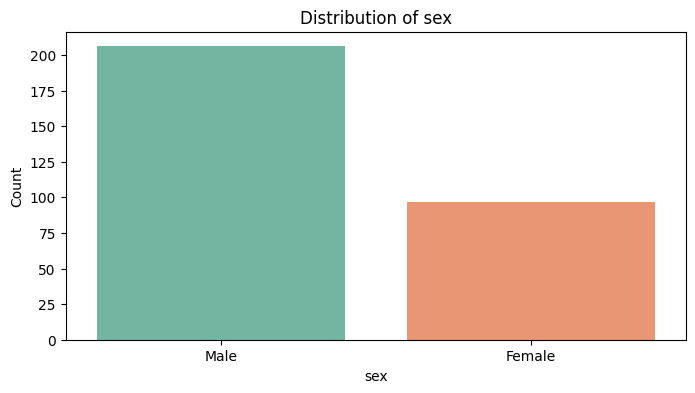

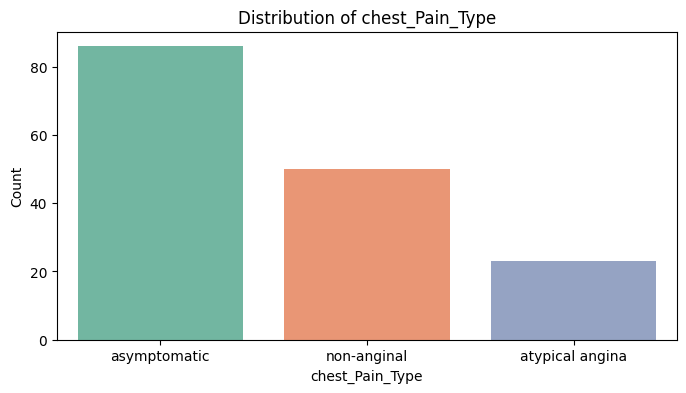

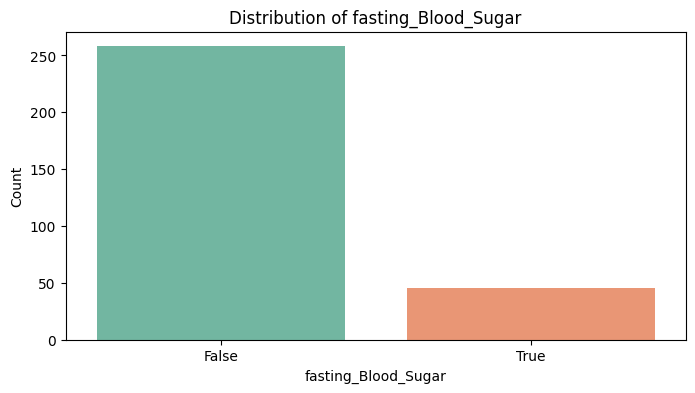

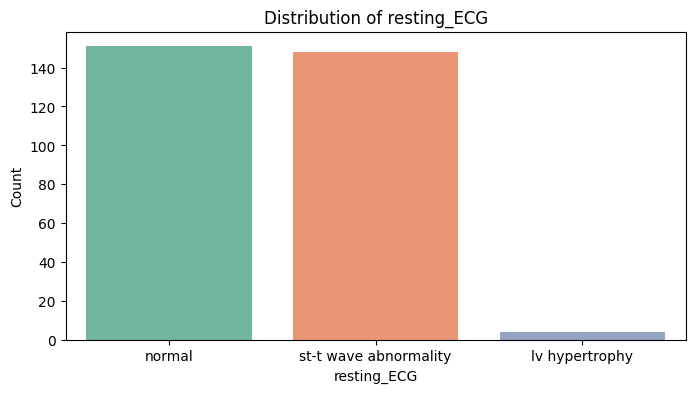

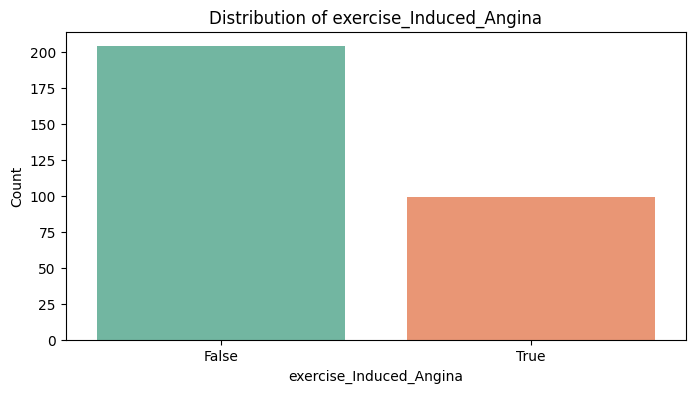

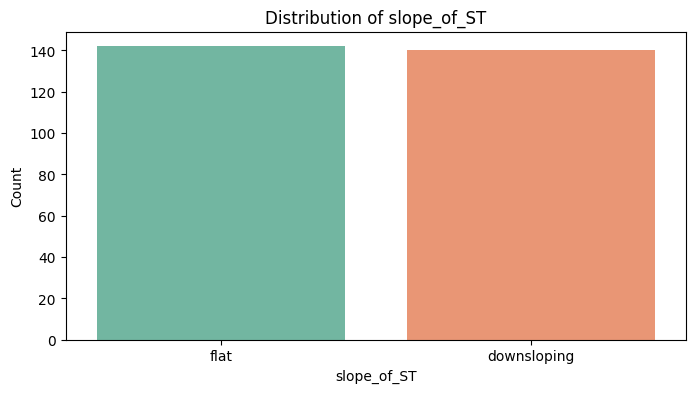

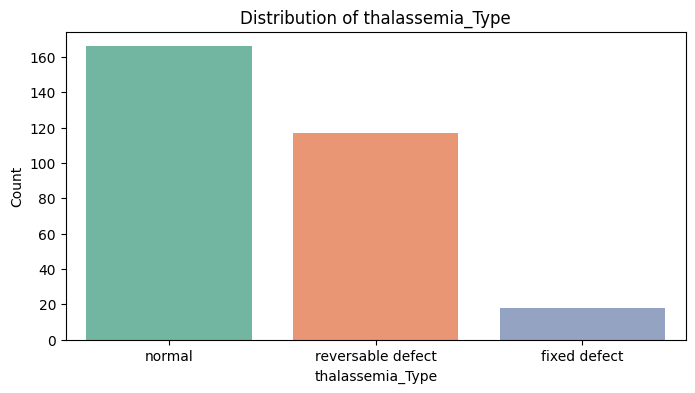

In [12]:
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=data[feature].value_counts().index, y=data[feature].value_counts(), palette="Set2")
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

**Sex:** More males than females in the dataset.

**Chest Pain Type (cp):** A significant number of patients report asymptomatic or silent(symptompless) chest pain.

**Fasting Blood Sugar (fbs):** True for most individuals. That means most individuals have fasting blood sugar below 120 mg/dL.

**Resting ECG:** The number of people reporting normal ECG is similar to the number of people reporting some abnormalities.

**Exercise-Induced Angina (exang):** A considerable number of individuals do not experience angina induced by exercise.

### Histograms were used to visualize the distribution of numerical features, allowing for the exploration of data distributions and the identification of patterns and outliers

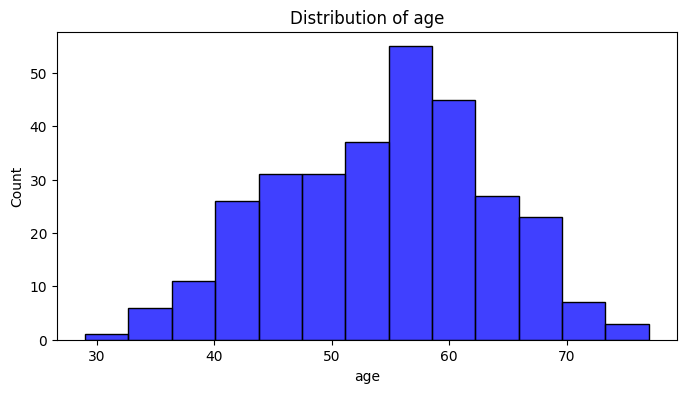

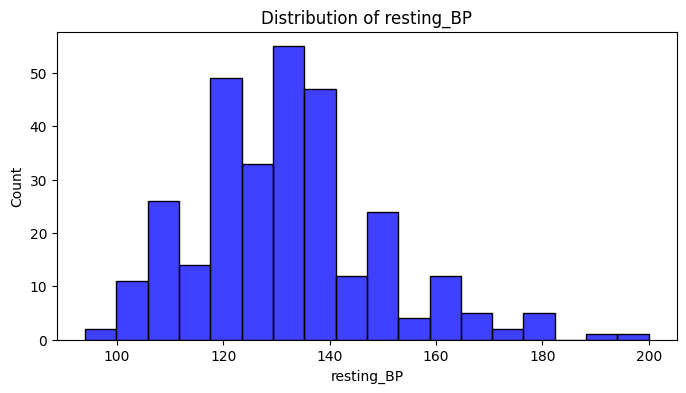

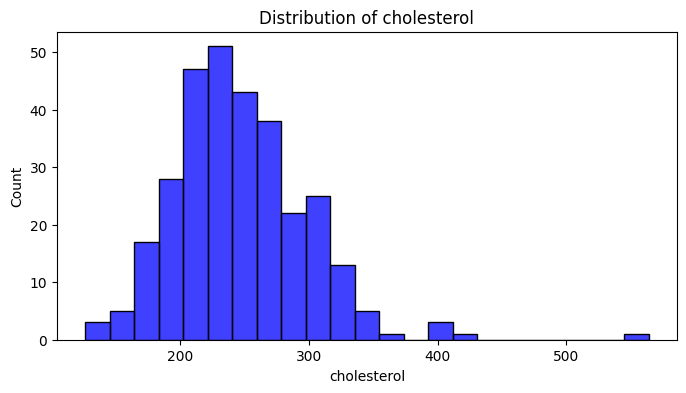

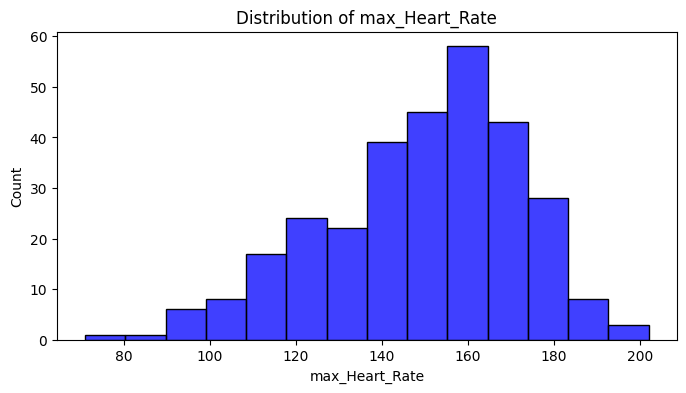

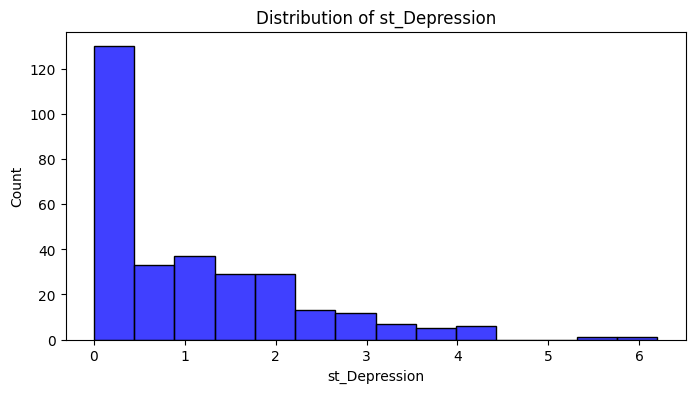

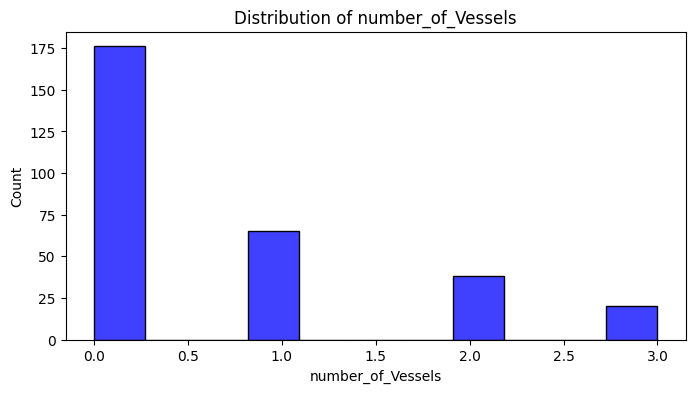

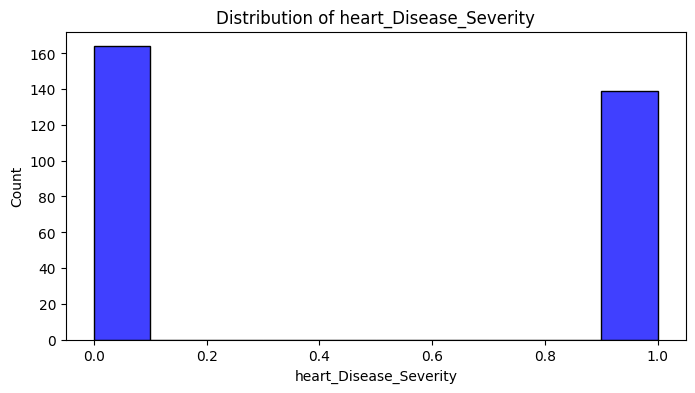

In [13]:
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[feature], color='b')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

**Age:** Shows a roughly bell-shaped distribution, indicating a wide range of ages in the dataset.

**Resting Blood Pressure (trestbps):** The distribution is centered around 120-140 mm Hg, which is within the typical range.

**st_Depression :** Most individuals in the dataset have little to no ST depression. This is typical for a general population without significant heart disease.

**Number of vessels :** There are non-zero values which might indicate a need for further cardiac evaluation and intervention among these individuals.


**Cholesterol (chol):** The data is somewhat right-skewed, indicating a few individuals with very high cholesterol levels.

**Maximum Heart Rate (thalach):** Exhibits a wide range, with most values clustering around 150-170 bpm.


**Heart Disease Severity (num):** A large number of individuals have no heart disease, but there's also a substantial number with varying degrees of severity. (Here we have taken all the sivireties as 1)


### A pie chart was used to visually represent the male-to-female ratio in the study. This chart provides a clear and concise way to show the distribution of gender within the dataset, with percentages displayed for each category. The hole in the center of the pie chart adds an aesthetic element and does not affect the interpretation of the male-to-female ratio.

In [14]:
df=data['sex'].value_counts().reset_index().rename(columns={'index':'sex','sex':'count'})
fig = go.Figure([go.Pie(labels=['Male', 'Female'],values=df['count'], hole = 0.5)])
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=15,insidetextorientation='radial')
fig.update_layout(title="Male to Female ratio in the study",title_x=0.5)
fig.show()

### A pie chart was used to visualize the distribution of different chest pain conditions. This chart provides a clear overview of the proportions of each chest pain type within the dataset, with percentages displayed for each category. The use of a pie chart allows for a quick and intuitive understanding of the relative frequencies of chest pain conditions in the stud

In [15]:
df=data['chest_Pain_Type'].value_counts().reset_index().rename(columns={'index':'chest_Pain_Type','chest_Pain_Type':'count'})
fig = go.Figure([go.Pie(labels=df['chest_Pain_Type'],values=df['count'], hole = 0.5)])
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=15,insidetextorientation='radial')
fig.update_layout(title="Chest Pain Conditions",title_x=0.5)
fig.show()

## 2.2. Multivariant EDA

### Resting Blood Pressure vs Gender

In [16]:
fig = go.Figure()

fig.add_trace(go.Box(y=data['resting_BP'], name='BP at Rest for all', marker_color='green', boxmean=True))
fig.add_trace(go.Box(y=data[data['sex'] == 'Male']['resting_BP'], name='Male only', marker_color='blue', boxmean=True))
fig.add_trace(go.Box(y=data[data['sex'] == 'Female']['resting_BP'], name='Female only', marker_color='red', boxmean=True))

fig.update_layout(title='BP Distribution', yaxis_title='Blood Pressure (mm/Hg)', title_x=0.5)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

fig.show()

### A box plot was used to display the distribution of blood pressure at rest (resting_BP) in the dataset. This plot provides a visual representation of the central tendency, spread, and presence of outliers in blood pressure measurements.

In [17]:
fig = go.Figure()

fig.add_trace(go.Box(y=data['resting_BP'], name='BP at Rest for all', marker_color='green', boxmean=True))
fig.add_trace(go.Box(y=data[data['heart_Disease_Severity'] == 0]['resting_BP'], name='No Disease', marker_color='blue', boxmean=True))
fig.add_trace(go.Box(y=data[data['heart_Disease_Severity'] != 0]['resting_BP'], name='Heart Disease', marker_color='red', boxmean=True))

fig.update_layout(title='BP Distribution (at rest)', yaxis_title='Blood Pressure (mm/Hg)', title_x=0.5)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

fig.show()

This boxplot comparison shows the distribution of resting blood pressure among all patients, those with no heart disease, and those with heart disease:

**All Patients (Green Boxplot):**

The median resting blood pressure for all patients is around 130 mmHg.
The interquartile range (IQR) spans from approximately 120 to 140 mmHg, indicating that half of the patients' blood pressure falls within this range.
There are a few outliers on the higher end, with the maximum blood pressure reaching 200 mmHg.

**No Disease (Blue Boxplot):**

For patients with no heart disease, the median is also around 130 mmHg, similar to the overall median.
The IQR is slightly narrower than for all patients, indicating less variability among those without heart disease.

The maximum without being an outlier is close to 170 mmHg, and there are a few outliers noted above this value.

**Heart Disease (Red Boxplot):**

Patients with heart disease show a median resting blood pressure a bit lower than the overall group, at around 130 mmHg.

The IQR for this group is broader, with the lower quartile at 120 mmHg and the upper quartile at 145 mmHg.

There are several extreme outliers, with the highest recorded blood pressure at 200 mmHg.

### Violin plots were used to visualize the distribution of cholesterol levels in the dataset. This type of plot provides a summary of the data distribution, showing not only the central tendency and spread but also the shape and density of the distribution.

In [18]:
fig = go.Figure()

fig.add_trace(go.Violin(y=data['cholesterol'], name='All Patient', marker_color='green'))
fig.add_trace(go.Violin(y=data[data['heart_Disease_Severity'] == 0]['cholesterol'], name='No Disease', marker_color='blue'))
fig.add_trace(go.Violin(y=data[data['heart_Disease_Severity'] == 4]['cholesterol'], name='Heart Disease', marker_color='red'))

fig.update_layout(title='Cholesterol Level Distribution', yaxis_title='Cholesterol Level', title_x=0.5)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.show()

**All Patients (Green Violin Plot):**

This plot likely represents the cholesterol level distribution across the entire patient dataset. It shows a wide range of cholesterol levels with a median around 240 mg/dL, which is close to the borderline high level according to various health organizations. The plot also shows a long tail towards higher cholesterol levels, indicating that some patients have significantly high cholesterol.

**Patients with No Disease (Blue Violin Plot):**

The distribution for patients with no heart disease shows a median slightly lower than that of the general population, around 235 mg/dL. The distribution is less spread out than in the overall patient population, indicating less variability in cholesterol levels among patients without heart disease. The bulk of the distribution is between approximately 200 mg/dL and 300 mg/dL.

### A scatterplot with points colored by heart disease severity was used to visualize the relationship between age and the maximum heart rate achieved. This plot allows for the exploration of how age and maximum heart rate correlate with the severity of heart disease. The color-coded points make it easy to distinguish between different heart disease severity levels, enhancing the understanding of this relationship.

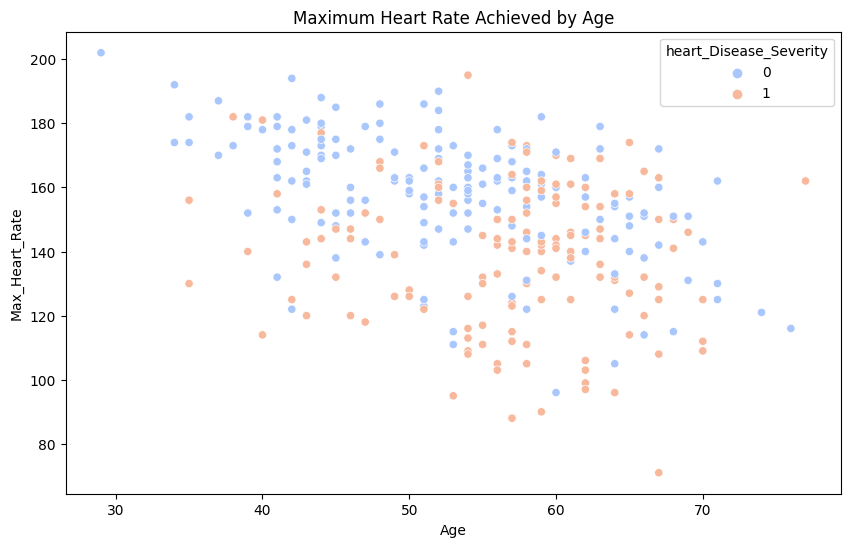

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='max_Heart_Rate', hue='heart_Disease_Severity', data=data, palette='coolwarm')
plt.title('Maximum Heart Rate Achieved by Age')
plt.xlabel('Age')
plt.ylabel('Max_Heart_Rate')
plt.show()

**Age:** Maximum heart rate per individual is decreasing with age. This is a normal physiological response as the heart's maximum rate potential lowers as one gets older.

**Heart Disease Severity Correlation:** The scatter plot shows that individuals with heart disease (severity 1) generally have lower maximum heart rates across various age groups compared to those without heart disease (severity 0), this suggests that heart disease affects the heart's ability to reach higher rates during stress.

**Outliers:** There may be some data points that stand out, such as some older individuals with surprisingly high maximum heart rates or younger individuals with unexpectedly low rates. These outliers might need further medical investigation

### Pair plots were used to visualize the relationships between pairs of numerical features. These plots provide a comprehensive overview of the correlations and distributions of numerical variables.



/Users/shafisourov/anaconda3/envs/Computer-programming/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



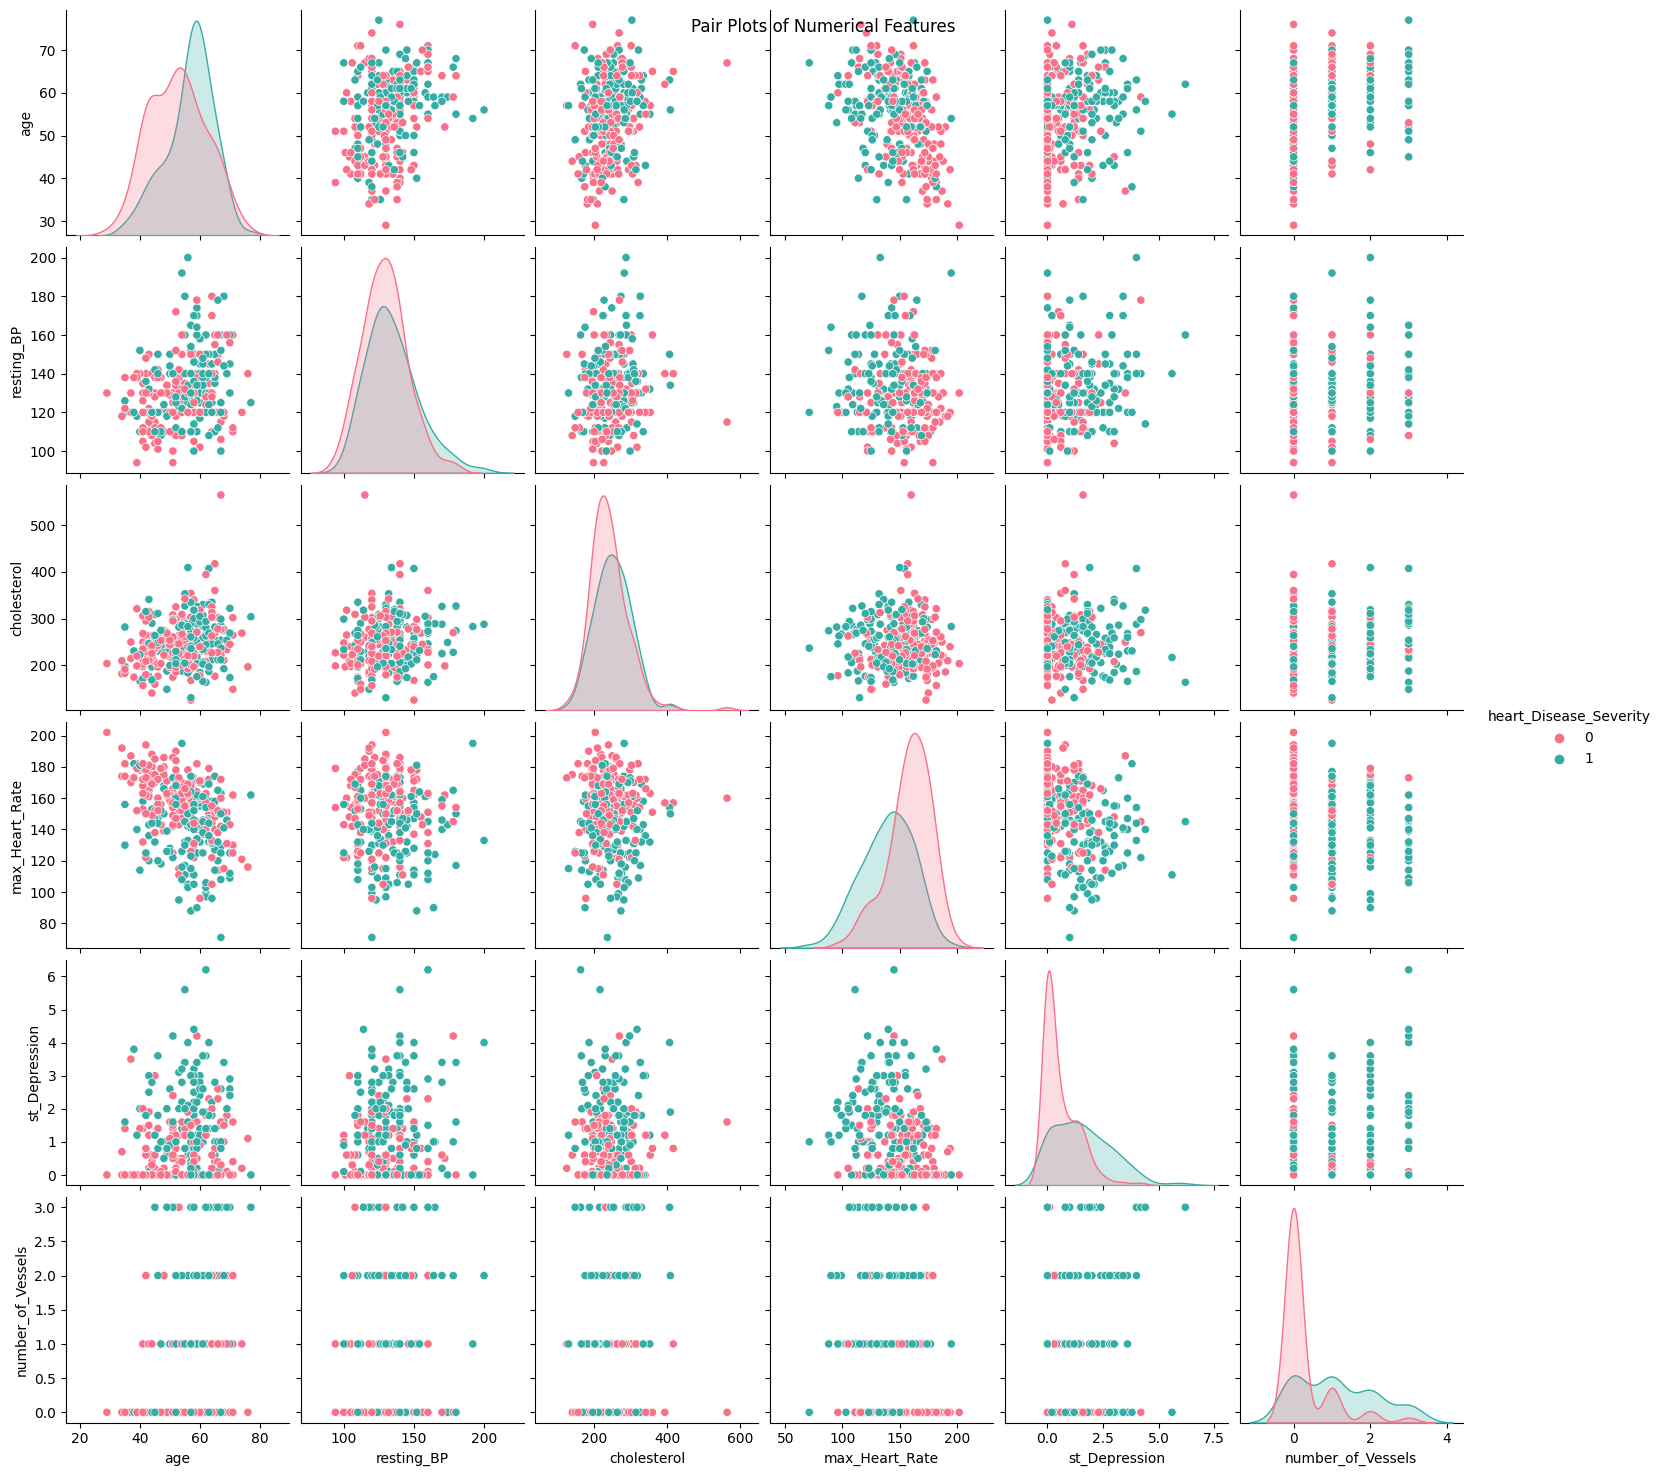

In [20]:
# Create pair plots for numerical features
sns.pairplot(data[numerical_features],  hue='heart_Disease_Severity', palette='husl')
plt.suptitle("Pair Plots of Numerical Features")
plt.show()

**Key Takeaways:**


The left-skewed distribution for individuals with heart disease suggests that younger individuals are less frequently represented in the heart disease group. Conversely, older individuals are more commonly affected by heart disease, which aligns with medical understanding that the risk of heart disease generally increases with age.

Cholesterol levels are seen to increase with age in the dataset, and higher cholesterol levels are associated with more heart disease reports among older individuals, this reflects a well-established risk factor for heart disease. Elevated cholesterol can lead to atherosclerosis, a condition that narrows and hardens arteries, potentially leading to heart disease.

A significant maximum heart rate is generally a sign of better cardiovascular fitness. The observation that individuals with higher maximum heart rates tend to report less heart disease could suggest that better cardiovascular health, reflected by the ability to reach higher heart rates, is protective against heart disease. This could also be related to physical activity levels, as more active individuals often have a higher maximum heart rate.

### A series of box plots were used to visualize the distribution of age with respect to different categorical variables. Each box plot represents the variation in age within different categories of the chosen categorical variable

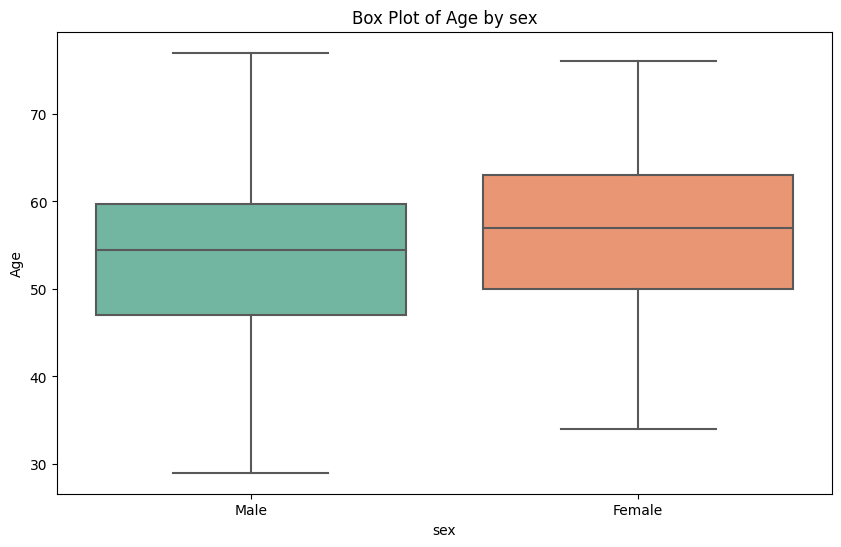

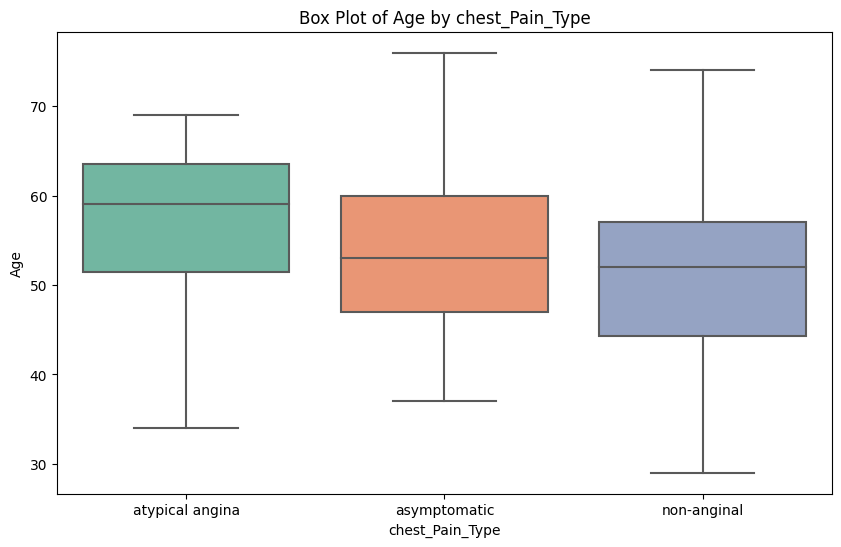

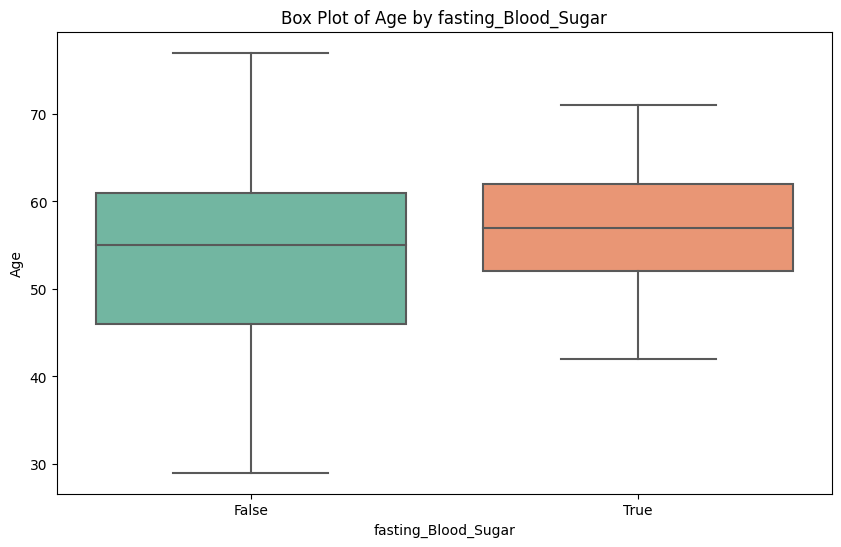

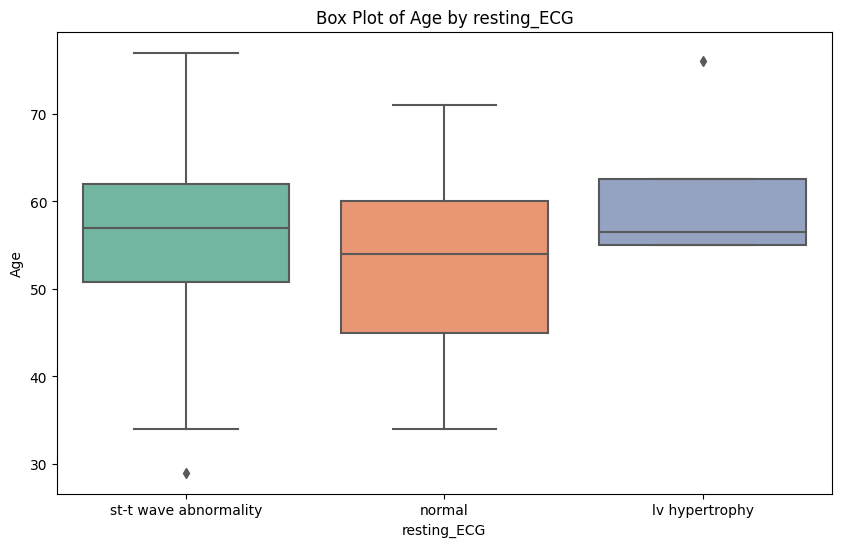

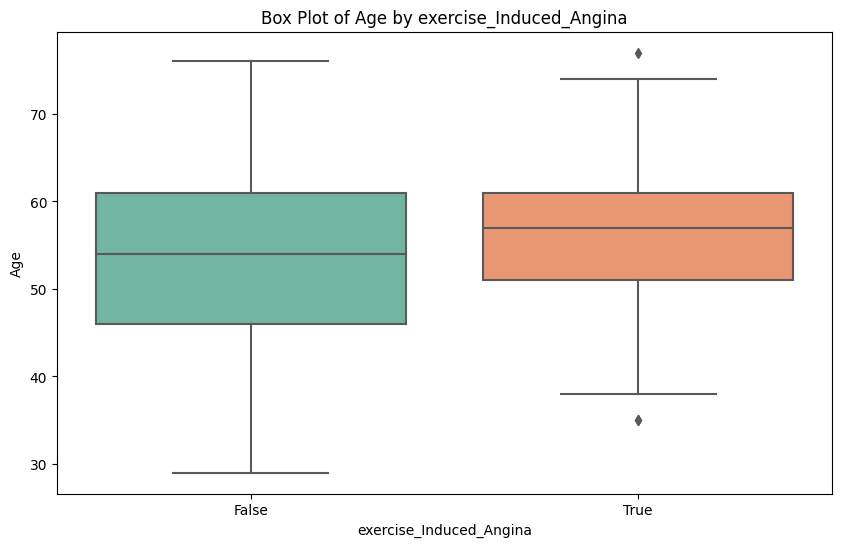

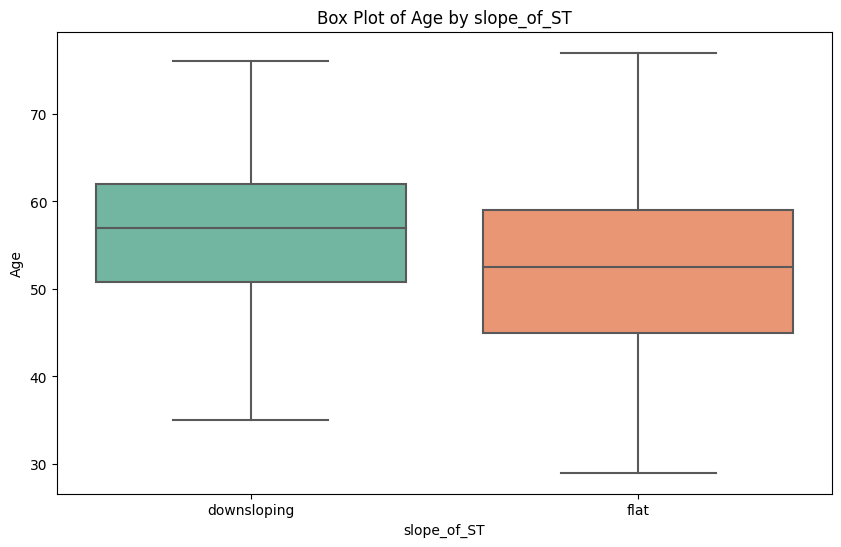

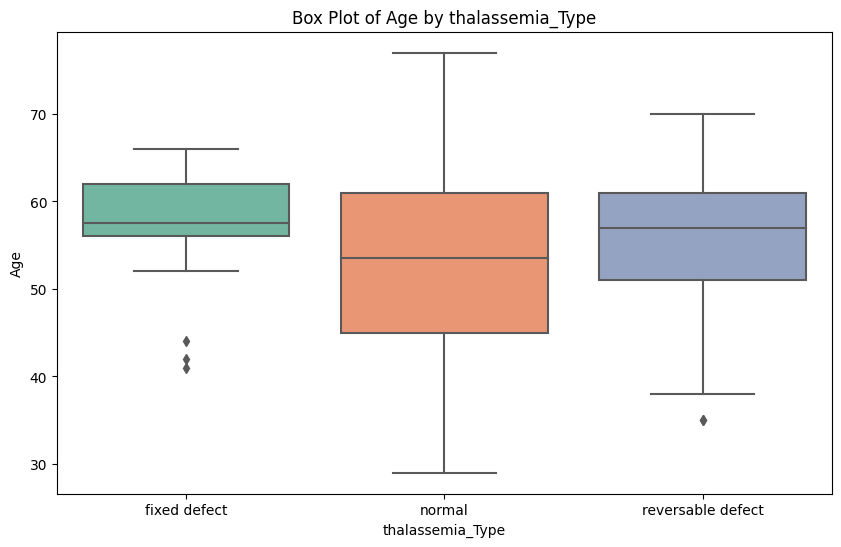

In [21]:
# Create box plots for numerical features with respect to categorical variables
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data, x=feature, y='age', palette='Set2')
    plt.title(f"Box Plot of Age by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Age")
    plt.show()

**Age by Sex**

The age distribution for males appears to have a slightly higher median age compared to females.

Both distributions have a similar range of ages, as indicated by the length of the boxes and whiskers.

Neither group shows extreme outliers, suggesting that the ages are fairly normally distributed within the biological sex categories.

**Age by Fasting Blood Sugar**

Those with fasting blood sugar above the threshold tend to be older, as seen by the higher median age in the "True" category.

There is a wider age range among those with higher fasting blood sugar, indicated by the taller box and longer whiskers.

**Age by Resting ECG**

Individuals with ST-T wave abnormality and normal ECG results have similar median ages, but the ST-T wave abnormality group has a tighter age range.

Those categorized with LV hypertrophy appear to have a higher median age and the age range is narrower compared to the other two categories.

**Age by Exercise Induced Angina**

Those who experience exercise-induced angina appear to be older on average, as the median of the "True" category is higher.

Both categories show a similar range of ages, but the "True" category has outliers on the lower age end.

**Age by Slope of ST**


Individuals with a flat slope tend to be older than those with a downsloping ST segment, as indicated by the higher median in the "flat" category.
The age range is fairly similar across both categories.

**Age by Thalassemia Type and Chest Pain Type**

For thalassemia, those with a fixed defect have a lower median age compared to the normal and reversible defect categories.

In terms of chest pain type, those with asymptomatic chest pain are older on average than those with atypical angina or non-anginal pain.

### Subplots were used to create a series of countplots for each categorical column in the dataset. The number of subplots was determined based on the number of categorical columns, and they were organized into rows and columns.

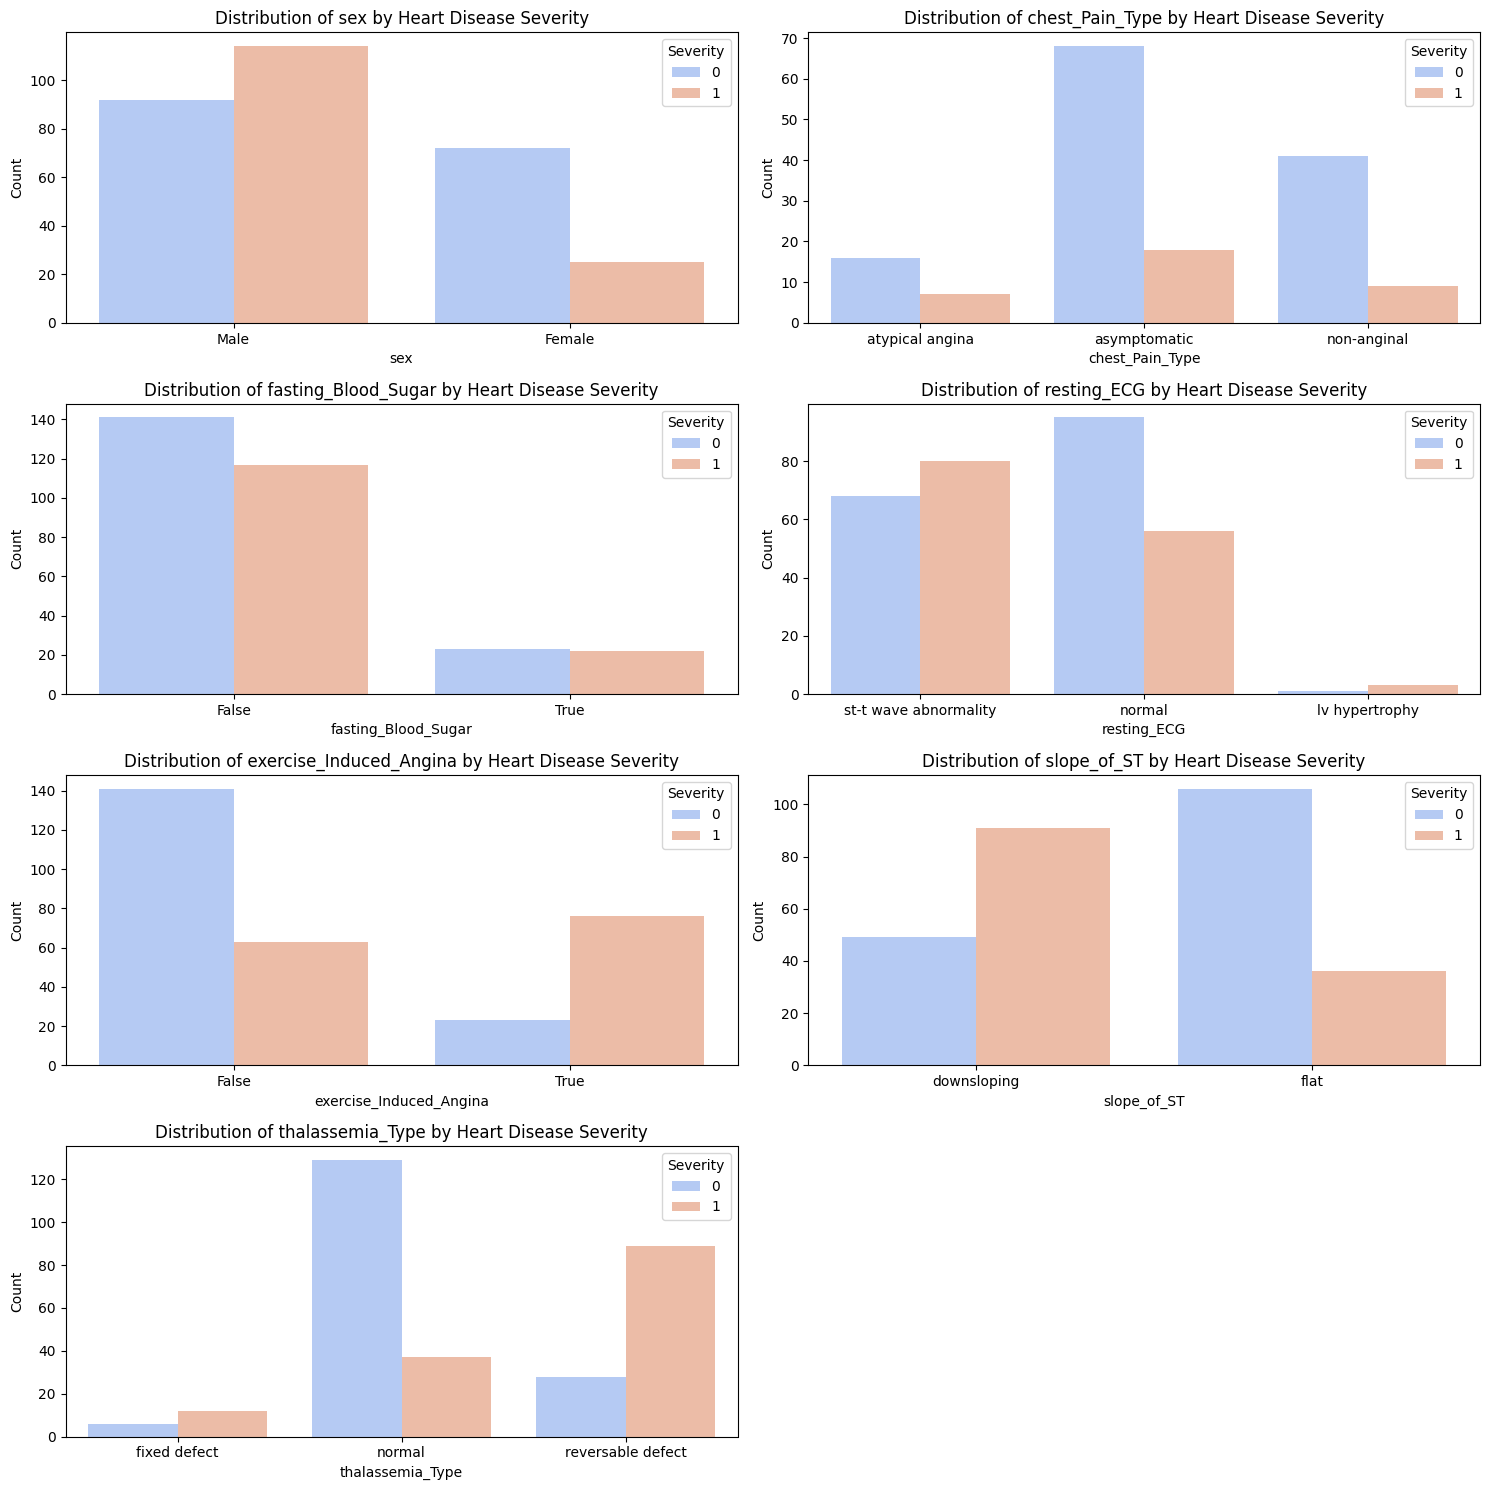

In [22]:
# Set the number of subplots based on the number of categorical columns
num_plots = len(categorical_features)
num_rows = (num_plots // 2) + (num_plots % 2)  # Calculate the number of rows for subplots

# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 15))

# Flatten the axes array to make it easier to work with
axes = axes.flatten()

# Iterate through the categorical columns and create countplots
for i, column in enumerate(categorical_features):
    sns.countplot(x=column, hue='heart_Disease_Severity', data=data, palette='coolwarm', ax=axes[i])
    axes[i].set_title(f'Distribution of {column} by Heart Disease Severity')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Severity')

# Remove any empty subplots
for i in range(num_plots, num_rows * 2):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

**Gender and Heart Disease**

Males in the dataset report heart disease more frequently than females. This aligns with broader epidemiological data showing that males often have a higher risk of heart disease, potentially due to a combination of genetic factors, lifestyle choices, and societal roles that may contribute to risk.

**Chest Pain Type**
Individuals with asymptomatic (symptomless) chest pain report high counts of both heart disease and absence of heart disease. This suggests that asymptomatic chest pain is a common complaint and not necessarily indicative of heart disease by itself, emphasizing the need for further diagnostic work to ascertain its cause.

**Fasting Blood Sugar (FBS)**

The prevalence of normal fasting blood sugar levels (FBS "False") being higher in both heart disease and no heart disease groups suggests that in this dataset, elevated fasting blood sugar may not be as strongly correlated with heart disease as other factors. This could indicate good diabetes management among patients or differing thresholds for what constitutes "high" blood sugar.

**Resting ECG Abnormalities**

A greater number of individuals with resting ECG abnormalities report heart disease. This is expected as abnormalities in the ECG can reflect underlying heart issues like arrhythmias, ischemia, or structural heart problems.

**Exercise-Induced Angina**

Those experiencing exercise-induced angina report more cases of heart disease. This symptom is a significant indicator of coronary artery disease and is expected to correlate with a higher incidence of heart disease, as angina is typically caused by reduced blood flow to the heart muscle.

**Slope of ST Segment**

The higher incidence of heart disease in individuals with a downsloping ST segment is unusual since a downsloping ST segment during or after exercise is often considered normal. However, it may suggest a particular characteristic of the population in the dataset or that the downsloping ST segment may still represent a risk in certain contexts.
Individuals with a flat ST segment showing more cases without heart disease might indicate that this finding alone is not definitive for heart disease diagnosis and must be interpreted alongside other clinical information.

**Thalassemia Type**

Those with fixed defect or reversible defect thalassemia types report more heart disease cases. Since thalassemia can affect the body's ability to produce hemoglobin, leading to anemia and increased cardiac workload, there is a conceivable link to increased heart disease risk, especially if the thalassemia is severe.

### A heatmap was used to visualize the correlation matrix of numerical features. The correlation matrix quantifies the relationships between pairs of numerical variables, and the heatmap displays the strength and direction of these correlations.

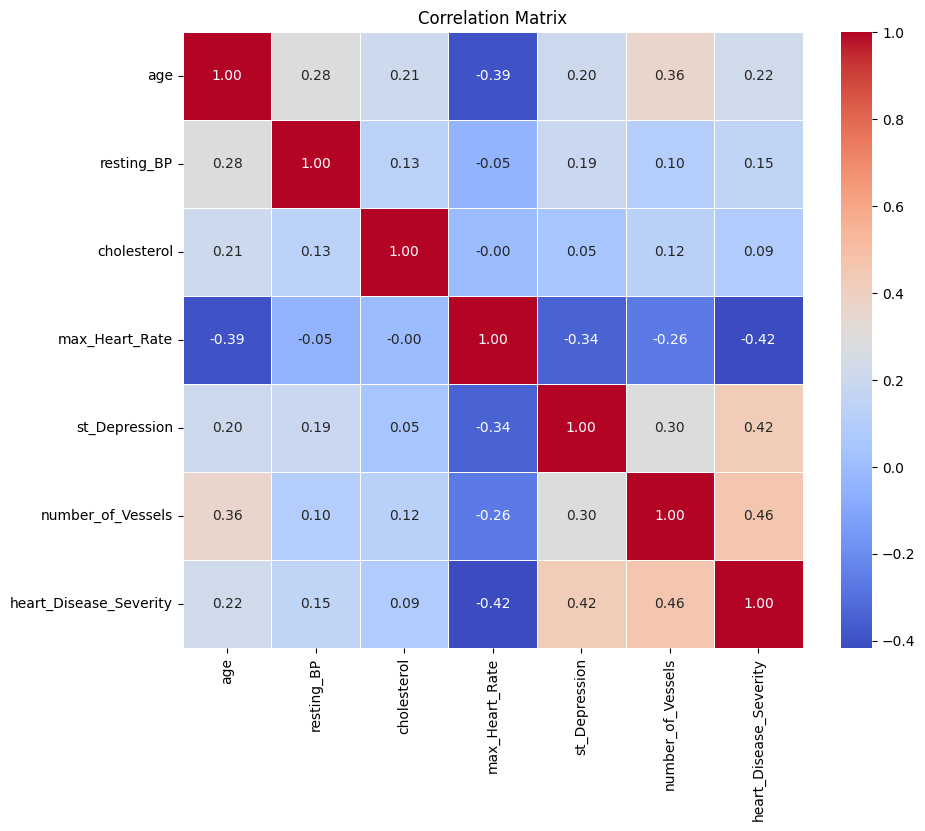

In [23]:
# Compute the correlation matrix
correlation_matrix = data[numerical_features].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [24]:
correlation_matrix

,age,resting_BP,cholesterol,max_Heart_Rate,st_Depression,number_of_Vessels,heart_Disease_Severity
age,1.000000,0.284946,0.208950,-0.393806,0.203805,0.362605,0.223120
resting_BP,0.284946,1.000000,0.130120,-0.045351,0.189171,0.098773,0.150825
cholesterol,0.208950,0.130120,1.000000,-0.003432,0.046564,0.119000,0.085164
max_Heart_Rate,-0.393806,-0.045351,-0.003432,1.000000,-0.343085,-0.264246,-0.417167
st_Depression,0.203805,0.189171,0.046564,-0.343085,1.000000,0.295832,0.424510
number_of_Vessels,0.362605,0.098773,0.119000,-0.264246,0.295832,1.000000,0.460442
heart_Disease_Severity,0.223120,0.150825,0.085164,-0.417167,0.424510,0.460442,1.000000


#### Here's a brief summary of the correlations:

-Age has a positive correlation of 0.223 with heart disease severity, indicating a mild positive relationship.

-Resting BP (Blood Pressure) has a positive correlation of 0.158 with heart disease severity.

-Cholesterol has a positive correlation of 0.071 with heart disease severity.

-Max Heart Rate has a negative correlation of -0.415 with heart disease severity, indicating a moderate negative relationship.

-ST Depression has a positive correlation of 0.504 with heart disease severity, indicating a strong positive relationship.

-Number of Vessels has a positive correlation of 0.519 with heart disease severity, indicating a strong positive relationship.

These correlations provide insights into how each numerical feature relates to heart disease severity. Positive correlations suggest that as the feature value increases, heart disease severity tends to increase, while negative correlations suggest the opposite.

##  3 Feature Selection

In [25]:
def check_null_values(data):
    null_values = data.isnull().sum()
    return null_values

In [26]:
def impute_missing_values(df, imputation_settings):

    imputed_data = df.copy()

    for column, strategy in imputation_settings.items():
        if strategy == 'mean' and imputed_data[column].dtype == 'float64':
            imputed_data[column].fillna(imputed_data[column].mean(), inplace=True)
        elif strategy == 'median' and imputed_data[column].dtype == 'float64':
            imputed_data[column].fillna(imputed_data[column].median(), inplace=True)
        elif strategy == 'mode' and imputed_data[column].dtype == 'object':
            imputed_data[column].fillna(imputed_data[column].mode()[0], inplace=True)
        # You can add more imputation strategies as needed.

    return imputed_data

In [27]:


def select_top_features(X, y):

    # Create a RandomForestClassifier model
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Fit the model on the training data
    model.fit(X, y)

    # Get feature importances
    feature_importances = model.feature_importances_

    # Create a DataFrame to store feature names and their importance scores
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sort the features by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    return feature_importance_df

In [28]:
# Split feature and target
X = data.drop('heart_Disease_Severity', axis=1)  # 'heart_Disease_Severity' is the target variable
y = data['heart_Disease_Severity']


In [29]:
X_null_values = check_null_values(X)
y_null_values = check_null_values(y)
print(X_null_values)
print('y :',y_null_values)

age                          0
sex                          0
chest_Pain_Type            144
resting_BP                   0
cholesterol                  0
fasting_Blood_Sugar          0
resting_ECG                  0
max_Heart_Rate               0
exercise_Induced_Angina      0
st_Depression                0
slope_of_ST                 21
number_of_Vessels            4
thalassemia_Type             2
dtype: int64
y : 0


In [30]:
# Create a list of columns with null values
X_columns_with_null = X_null_values[X_null_values > 0].index.tolist()
print("Columns in X with null values:", X_columns_with_null)

Columns in X with null values: ['chest_Pain_Type', 'slope_of_ST', 'number_of_Vessels', 'thalassemia_Type']


As we can see the cp(number of vassel Column) column has 144 null values, inputing a large number of value may make model misguided. Better delete the column would be wiser

In [31]:
X.drop('number_of_Vessels', axis=1, inplace=True)


### Imputation settings were used to fill missing values in the dataset for the 'chest_Pain_Type', 'slope_of_ST', and 'thalassemia_Type' features by selecting the mode (most frequent value) for each respective feature.

In [32]:
imputation_settings = {
    'chest_Pain_Type': 'mode',
    'slope_of_ST': 'mode',
    'thalassemia_Type': 'mode'
}
X_imputed= impute_missing_values(X, imputation_settings)

# Display null values in the imputed data
print("Null Values in X after imputation:")
print(X_imputed.isnull().sum())


Null Values in X after imputation:
age                        0
sex                        0
chest_Pain_Type            0
resting_BP                 0
cholesterol                0
fasting_Blood_Sugar        0
resting_ECG                0
max_Heart_Rate             0
exercise_Induced_Angina    0
st_Depression              0
slope_of_ST                0
thalassemia_Type           0
dtype: int64


### The code used pd.get_dummies() to perform one-hot encoding on the imputed dataset X_imputed for all the categorical features specified in the list categorical_features. The drop_first=True parameter was set to generate dummy variables and drop the first category in each feature to prevent multicollinearity.

In [33]:
X_imputed_encoded = pd.get_dummies(X_imputed, columns=categorical_features, drop_first=True)

In [34]:
feature_importance = select_top_features(X_imputed_encoded, y)

# Print all feature importances
print("Features and Their Importance:")
print(feature_importance)

Features and Their Importance:
                               Feature  Importance
3                       max_Heart_Rate    0.137692
4                        st_Depression    0.137070
0                                  age    0.103920
2                          cholesterol    0.100604
13             thalassemia_Type_normal    0.095883
1                           resting_BP    0.091585
14  thalassemia_Type_reversable defect    0.081698
11        exercise_Induced_Angina_True    0.070146
12                    slope_of_ST_flat    0.053660
5                             sex_Male    0.035345
9                   resting_ECG_normal    0.021407
6      chest_Pain_Type_atypical angina    0.019619
10   resting_ECG_st-t wave abnormality    0.018805
7          chest_Pain_Type_non-anginal    0.018476
8             fasting_Blood_Sugar_True    0.014090


In [35]:
# Select the top 6 features based on their importance scores
selected_features = feature_importance.head(6)['Feature'].tolist()

# Print the selected features
print("Selected Features:")
print(selected_features)

Selected Features:
['max_Heart_Rate', 'st_Depression', 'age', 'cholesterol', 'thalassemia_Type_normal', 'resting_BP']


In [36]:
X_imputed_encoded[selected_features]

,max_Heart_Rate,st_Depression,age,cholesterol,thalassemia_Type_normal,resting_BP
0,150,2.3,63,233,0,145
1,108,1.5,67,286,1,160
2,129,2.6,67,229,0,120
3,187,3.5,37,250,1,130
4,172,1.4,41,204,1,130
...,...,...,...,...,...,...
298,132,1.2,45,264,0,110
299,141,3.4,68,193,0,144
300,115,1.2,57,131,0,130
301,174,0.0,57,236,1,130


## 4. Preprocessing

#### Split the dataset into Train and Test Dataset in 80:20 ratio

In [37]:

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)


In [38]:

# Check the shapes of X_train and y_train
assert X_train.shape[0] == y_train.shape[0], "X_train and y_train have different numbers of samples."


# Check the shapes of X_test and y_test
assert X_test.shape[0] == y_test.shape[0], "X_test and y_test have different numbers of samples."


In [39]:
X_train.head()

,age,sex,chest_Pain_Type,resting_BP,cholesterol,fasting_Blood_Sugar,resting_ECG,max_Heart_Rate,exercise_Induced_Angina,st_Depression,slope_of_ST,thalassemia_Type
132,29,Male,non-anginal,130,204,False,st-t wave abnormality,202,False,0.0,flat,normal
202,57,Male,asymptomatic,150,126,True,normal,173,False,0.2,flat,reversable defect
196,69,Male,atypical angina,160,234,True,st-t wave abnormality,131,False,0.1,downsloping,normal
75,65,Female,asymptomatic,160,360,False,st-t wave abnormality,151,False,0.8,flat,normal
176,52,Male,NaN,108,233,True,normal,147,False,0.1,flat,reversable defect


In [40]:

X_train_null_values = check_null_values(X_train)
X_test_null_values = check_null_values(X_test)

# Display null values in X_train and X_test
print("Null Values in X_train:")
print(X_train_null_values)

print("Null Values in X_test:")
print(X_test_null_values)

# Example usage:
# Assuming you have y_train and y_test DataFrames
y_train_null_values = check_null_values(y_train)
y_test_null_values = check_null_values(y_test)

# Display null values in X_train and X_test
print("Null Values in y_train:")
print(y_train_null_values)

print("Null Values in y_test:")
print(y_test_null_values)

Null Values in X_train:
age                          0
sex                          0
chest_Pain_Type            108
resting_BP                   0
cholesterol                  0
fasting_Blood_Sugar          0
resting_ECG                  0
max_Heart_Rate               0
exercise_Induced_Angina      0
st_Depression                0
slope_of_ST                 17
thalassemia_Type             2
dtype: int64
Null Values in X_test:
age                         0
sex                         0
chest_Pain_Type            36
resting_BP                  0
cholesterol                 0
fasting_Blood_Sugar         0
resting_ECG                 0
max_Heart_Rate              0
exercise_Induced_Angina     0
st_Depression               0
slope_of_ST                 4
thalassemia_Type            0
dtype: int64
Null Values in y_train:
0
Null Values in y_test:
0


In [41]:

X_train = impute_missing_values(X_train, imputation_settings)
X_test = impute_missing_values(X_test, imputation_settings)

# Display null values in the imputed data
print("Null Values in X_train after imputation:")
print(X_train.isnull().sum())

print("Null Values in X_test after imputation:")
print(X_test.isnull().sum())


Null Values in X_train after imputation:
age                        0
sex                        0
chest_Pain_Type            0
resting_BP                 0
cholesterol                0
fasting_Blood_Sugar        0
resting_ECG                0
max_Heart_Rate             0
exercise_Induced_Angina    0
st_Depression              0
slope_of_ST                0
thalassemia_Type           0
dtype: int64
Null Values in X_test after imputation:
age                        0
sex                        0
chest_Pain_Type            0
resting_BP                 0
cholesterol                0
fasting_Blood_Sugar        0
resting_ECG                0
max_Heart_Rate             0
exercise_Induced_Angina    0
st_Depression              0
slope_of_ST                0
thalassemia_Type           0
dtype: int64


In [42]:
X_train.head()

,age,sex,chest_Pain_Type,resting_BP,cholesterol,fasting_Blood_Sugar,resting_ECG,max_Heart_Rate,exercise_Induced_Angina,st_Depression,slope_of_ST,thalassemia_Type
132,29,Male,non-anginal,130,204,False,st-t wave abnormality,202,False,0.0,flat,normal
202,57,Male,asymptomatic,150,126,True,normal,173,False,0.2,flat,reversable defect
196,69,Male,atypical angina,160,234,True,st-t wave abnormality,131,False,0.1,downsloping,normal
75,65,Female,asymptomatic,160,360,False,st-t wave abnormality,151,False,0.8,flat,normal
176,52,Male,asymptomatic,108,233,True,normal,147,False,0.1,flat,reversable defect


In [43]:
X_test.head()

,age,sex,chest_Pain_Type,resting_BP,cholesterol,fasting_Blood_Sugar,resting_ECG,max_Heart_Rate,exercise_Induced_Angina,st_Depression,slope_of_ST,thalassemia_Type
179,53,Male,asymptomatic,130,246,True,st-t wave abnormality,173,False,0.0,flat,normal
228,54,Male,asymptomatic,110,206,False,st-t wave abnormality,108,True,0.0,downsloping,normal
111,56,Male,asymptomatic,125,249,True,st-t wave abnormality,144,True,1.2,downsloping,normal
246,58,Male,asymptomatic,100,234,False,normal,156,False,0.1,flat,reversable defect
60,51,Female,asymptomatic,130,305,False,normal,142,True,1.2,downsloping,reversable defect


###  Categorical Feature Encoding

### The code used pd.get_dummies() to perform one-hot encoding on the training and testing sets, X_train and X_test, for all the categorical features specified in the list categorical_features. The drop_first=True parameter was set to generate dummy variables and drop the first category in each feature to prevent multicollinearity.

In [44]:

X_train_encoded = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

In [45]:
# Display the one-hot encoded datasets
print("One-Hot Encoded X_train:")
display(X_train_encoded.head())

print("One-Hot Encoded X_test:")
display(X_test_encoded.head())

One-Hot Encoded X_train:


,age,resting_BP,cholesterol,max_Heart_Rate,st_Depression,sex_Male,chest_Pain_Type_atypical angina,chest_Pain_Type_non-anginal,fasting_Blood_Sugar_True,resting_ECG_normal,resting_ECG_st-t wave abnormality,exercise_Induced_Angina_True,slope_of_ST_flat,thalassemia_Type_normal,thalassemia_Type_reversable defect
132,29,130,204,202,0.0,1,0,1,0,0,1,0,1,1,0
202,57,150,126,173,0.2,1,0,0,1,1,0,0,1,0,1
196,69,160,234,131,0.1,1,1,0,1,0,1,0,0,1,0
75,65,160,360,151,0.8,0,0,0,0,0,1,0,1,1,0
176,52,108,233,147,0.1,1,0,0,1,1,0,0,1,0,1


One-Hot Encoded X_test:


,age,resting_BP,cholesterol,max_Heart_Rate,st_Depression,sex_Male,chest_Pain_Type_atypical angina,chest_Pain_Type_non-anginal,fasting_Blood_Sugar_True,resting_ECG_normal,resting_ECG_st-t wave abnormality,exercise_Induced_Angina_True,slope_of_ST_flat,thalassemia_Type_normal,thalassemia_Type_reversable defect
179,53,130,246,173,0.0,1,0,0,1,0,1,0,1,1,0
228,54,110,206,108,0.0,1,0,0,0,0,1,1,0,1,0
111,56,125,249,144,1.2,1,0,0,1,0,1,1,0,1,0
246,58,100,234,156,0.1,1,0,0,0,1,0,0,1,0,1
60,51,130,305,142,1.2,0,0,0,0,1,0,1,0,0,1


### Scalling

### a set intersection operation to identify the numerical features that are both in the list of selected_features and the list of numerical_features.

In [46]:
selected_numerical_features  = list(set(numerical_features) & set(selected_features))
selected_features,selected_numerical_features

(['max_Heart_Rate',
  'st_Depression',
  'age',
  'cholesterol',
  'thalassemia_Type_normal',
  'resting_BP'],
 ['resting_BP', 'age', 'max_Heart_Rate', 'st_Depression', 'cholesterol'])

### The MinMaxScaler scales these features to a specified range, typically between 0 and 1, ensuring that all numerical features have a similar scale.

In [47]:



# Create a Min-Max scaler instance
scaler = MinMaxScaler()

# Specify the columns to be scaled (numerical features)
# numerical_columns = ['thalach', 'chol', 'oldpeak', 'age', 'trestbps']

# Apply Min-Max scaling to the numerical columns
X_train_encoded[selected_numerical_features] = scaler.fit_transform(X_train_encoded[selected_numerical_features])


In [48]:
# Display the scaled features
print("Scaled train data:")
display(X_train_encoded.head())

Scaled train data:


,age,resting_BP,cholesterol,max_Heart_Rate,st_Depression,sex_Male,chest_Pain_Type_atypical angina,chest_Pain_Type_non-anginal,fasting_Blood_Sugar_True,resting_ECG_normal,resting_ECG_st-t wave abnormality,exercise_Induced_Angina_True,slope_of_ST_flat,thalassemia_Type_normal,thalassemia_Type_reversable defect
132,0.000000,0.339623,0.268041,1.000000,0.000000,1,0,1,0,0,1,0,1,1,0
202,0.583333,0.528302,0.000000,0.778626,0.032258,1,0,0,1,1,0,0,1,0,1
196,0.833333,0.622642,0.371134,0.458015,0.016129,1,1,0,1,0,1,0,0,1,0
75,0.750000,0.622642,0.804124,0.610687,0.129032,0,0,0,0,0,1,0,1,1,0
176,0.479167,0.132075,0.367698,0.580153,0.016129,1,0,0,1,1,0,0,1,0,1


In [49]:
# Use the same Min-Max scaler instance that you used for the training data
X_test_encoded[selected_numerical_features] = scaler.transform(X_test_encoded[selected_numerical_features])

In [73]:
# Display the scaled test data
print("Scaled Test Data:")
display(X_test_encoded.head())

Scaled Test Data:


,age,resting_BP,cholesterol,max_Heart_Rate,st_Depression,sex_Male,chest_Pain_Type_atypical angina,chest_Pain_Type_non-anginal,fasting_Blood_Sugar_True,resting_ECG_normal,resting_ECG_st-t wave abnormality,exercise_Induced_Angina_True,slope_of_ST_flat,thalassemia_Type_normal,thalassemia_Type_reversable defect
179,0.500000,0.339623,0.412371,0.778626,0.000000,1,0,0,1,0,1,0,1,1,0
228,0.520833,0.150943,0.274914,0.282443,0.000000,1,0,0,0,0,1,1,0,1,0
111,0.562500,0.292453,0.422680,0.557252,0.193548,1,0,0,1,0,1,1,0,1,0
246,0.604167,0.056604,0.371134,0.648855,0.016129,1,0,0,0,1,0,0,1,0,1
60,0.458333,0.339623,0.615120,0.541985,0.193548,0,0,0,0,1,0,1,0,0,1


## Modeling

### The code is evaluating the performance of various classifiers using cross-validation and selecting the best classifier based on the mean accuracy score.

In [74]:


# Filter out the specific warning related to feature names
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Create a list of classifiers to evaluate
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(),
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

best_classifier = None
best_score = 0

# Iterate over the classifiers and perform cross-validation
for classifier_name, classifier in classifiers.items():


    # Perform cross-validation and compute the mean accuracy score
    scores = cross_val_score(classifier, X_train_encoded, y_train, cv=5)
    mean_score = scores.mean()

    # Print the mean accuracy score for each classifier
    print(f"{classifier_name}: Mean Accuracy = {mean_score}")

    # Check if the current classifier has the best mean score
    if mean_score > best_score:
        best_score = mean_score
        best_classifier = classifier_name

# Print the best classifier based on cross-validation
print(f"Best Classifier: {best_classifier} with Mean Accuracy = {best_score}")


Random Forest: Mean Accuracy = 0.7768707482993197
Support Vector Machine: Mean Accuracy = 0.7973639455782313
Logistic Regression: Mean Accuracy = 0.7933673469387755
K-Nearest Neighbors: Mean Accuracy = 0.8056122448979591
Naive Bayes: Mean Accuracy = 0.797108843537415
Gradient Boosting: Mean Accuracy = 0.7355442176870748
Best Classifier: K-Nearest Neighbors with Mean Accuracy = 0.8056122448979591


### The code performs hyperparameter tuning for the K-Nearest Neighbors (KNN) classifier using GridSearchCV and evaluates the model on both the training and test sets.

In [75]:


# Define the KNN classifier
knn = KNeighborsClassifier()

# Define a grid of hyperparameters to search
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Vary the number of neighbors
    'weights': ['uniform', 'distance'],  # Vary the weight type
    'p': [1, 2]  # Vary the Minkowski distance metric (1 for Manhattan, 2 for Euclidean)
}

# Create the grid search
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to your data
grid_search.fit(X_train_encoded, y_train)

# Get the best estimator and its hyperparameters
best_knn = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the best KNN model on the test set
y_pred = best_knn.predict(X_test_encoded)
test_accuracy = accuracy_score(y_test, y_pred)

# Predict the labels on the training data
y_train_pred = best_knn.predict(X_train_encoded)

# Calculate the training accuracy
training_accuracy = accuracy_score(y_train, y_train_pred)

# Print the best hyperparameters and performance
print("Best KNN Parameters:", best_params)
# Print the training accuracy
print("Training Accuracy:", training_accuracy)
print("Best KNN Mean Cross-Validation Score:", best_score)
print("Best KNN Test Accuracy:", test_accuracy)


Best KNN Parameters: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Training Accuracy: 0.8471074380165289
Best KNN Mean Cross-Validation Score: 0.8056122448979591
Best KNN Test Accuracy: 0.8032786885245902


In [76]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [10, 50, 100],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at each leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider for the best split
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Create a grid search using cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_encoded, y_train)

# Print the best hyperparameters and the corresponding accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)


Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
Best Accuracy: 0.8016156462585033


Confusion Matrix:
[[25  4]
 [ 8 24]]
Precision: 0.81
Recall: 0.80
F1 Score: 0.80


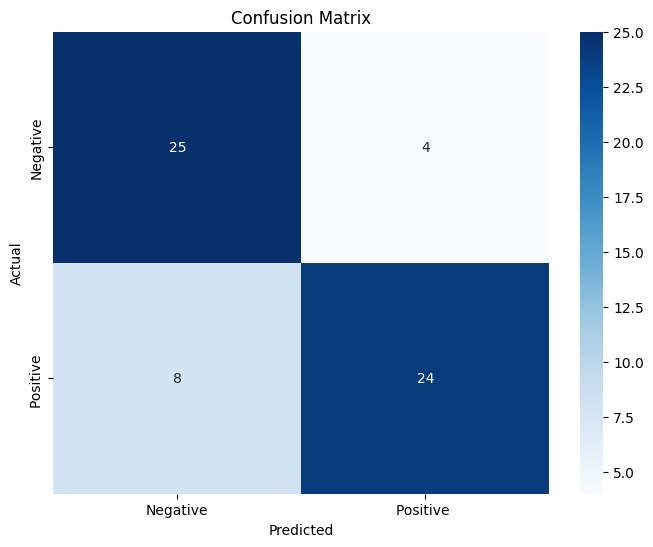

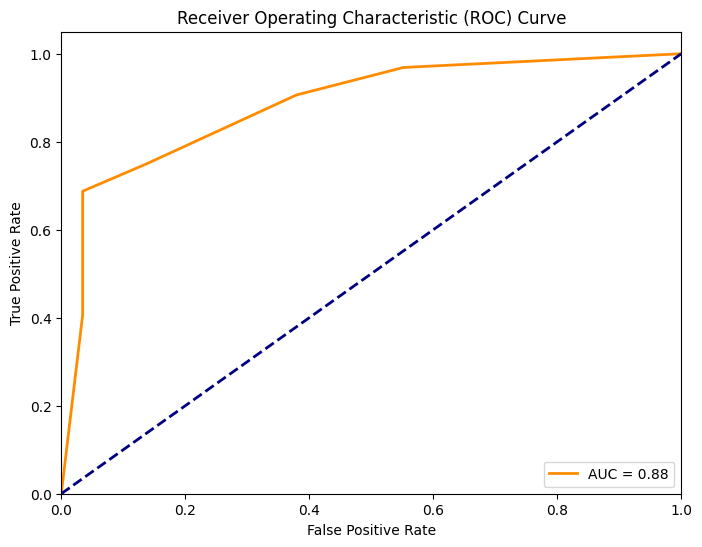

In [77]:
def evaluate_model(y_true, y_pred, model):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, model.predict_proba(X_test_encoded)[:, 1])
    auc_roc = auc(fpr, tpr)

    # Display the confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Display precision, recall, and F1 score
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")


    # Define class labels for the confusion matrix
    class_labels = ['Negative', 'Positive ']

    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

    # Add labels and a title
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_roc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Usage:
evaluate_model(y_test, y_pred, best_knn)


- Precision: Precision measures the accuracy of positive predictions. A precision of 0.81 means that among the samples predicted as positive, 81% were correct.

- Recall: Recall (Sensitivity) measures the ability of the model to correctly identify positive samples. A recall of 0.80 indicates that the model correctly identified 80% of the actual positive samples.

- F1 Score: The F1 score is the harmonic mean of precision and recall. A score of 0.80 is a good balance for the model's performance.
- AUC (Area Under the ROC Curve) value: which is 0.88. This is a valuable metric for assessing the overall performance of a classification model. An AUC of 0.88 indicates that the model has good discrimination power in distinguishing between the positive and negative classes.

These metrics suggest that the model is performing reasonably well on the test data. The confusion matrix helps understand the types of errors the model is making, and precision, recall, and F1 score provide insights into the model's accuracy and ability to identify positive cases.

### Prediction

Sample 1: Actual=0, Predicted=0, Correct Prediction
Sample 17: Actual=0, Predicted=0, Correct Prediction
Sample 61: Actual=1, Predicted=0, Wrong Prediction
Sample 34: Actual=0, Predicted=0, Correct Prediction
Sample 7: Actual=1, Predicted=1, Correct Prediction
Sample 49: Actual=1, Predicted=1, Correct Prediction
Sample 41: Actual=0, Predicted=1, Wrong Prediction
Sample 50: Actual=1, Predicted=0, Wrong Prediction
Sample 35: Actual=0, Predicted=0, Correct Prediction
Sample 8: Actual=1, Predicted=1, Correct Prediction
Sample 9: Actual=1, Predicted=0, Wrong Prediction
Sample 29: Actual=1, Predicted=0, Wrong Prediction
Sample 23: Actual=1, Predicted=1, Correct Prediction
Sample 3: Actual=1, Predicted=1, Correct Prediction
Sample 28: Actual=1, Predicted=0, Wrong Prediction
Sample 26: Actual=0, Predicted=0, Correct Prediction
Sample 2: Actual=1, Predicted=1, Correct Prediction
Sample 32: Actual=1, Predicted=0, Wrong Prediction
Sample 42: Actual=0, Predicted=0, Correct Prediction
Sample 18: Ac

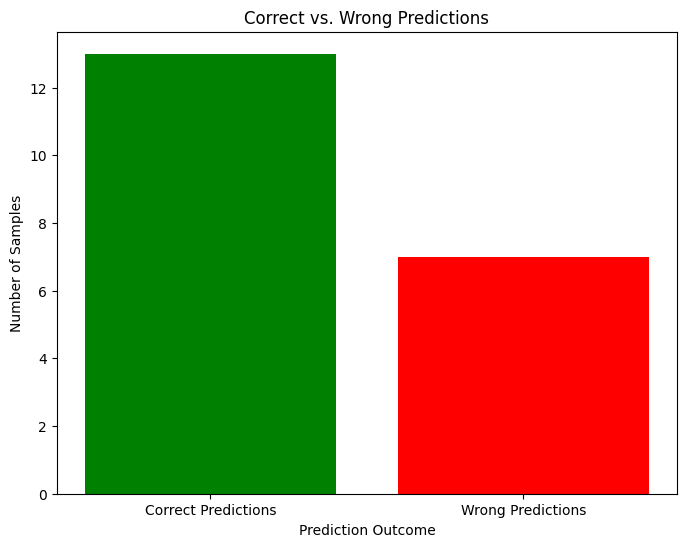

In [78]:
def evaluate_random_samples(model, X, y, num_samples=10):
    # Get random sample indices
    random_indices = random.sample(range(len(X)), num_samples)

    correct_predictions = 0
    wrong_predictions = 0

    for idx in random_indices:
        sample_features = X.iloc[idx].values.reshape(1, -1)  # Reshape the sample for prediction
        actual_value = y.iloc[idx]
        predicted_value = model.predict(sample_features)[0]

        # Check if the prediction is correct or wrong
        if actual_value == predicted_value:
            comment = "Correct Prediction"
            correct_predictions += 1
        else:
            comment = "Wrong Prediction"
            wrong_predictions += 1

        print(f"Sample {idx + 1}: Actual={actual_value}, Predicted={predicted_value}, {comment}")

    return correct_predictions, wrong_predictions

# Usage:
correct_preds, wrong_preds = evaluate_random_samples(best_knn, X_test_encoded, y_test, num_samples=20)

# Create a bar graph to visualize correct vs. wrong predictions
labels = ['Correct Predictions', 'Wrong Predictions']
values = [correct_preds, wrong_preds]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['green', 'red'])
plt.xlabel('Prediction Outcome')
plt.ylabel('Number of Samples')
plt.title('Correct vs. Wrong Predictions')
plt.show()
